Tommaso Peritore

In [18]:
#matplotlib
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import matplotlib.gridspec as gridspec
from scipy.optimize import curve_fit
import statsmodels.api as sm
from matplotlib.ticker import FixedLocator


#numpy
import numpy as np

#center graphs
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
	display: table-cell;
	text-align: center;
	vertical-align: middle;
}
</style>
""")
colors = ["steelblue" , "firebrick" , "cadetblue" , "indianred"]


# Exercise 08

The variational principle in Quantum Mechanics states that the expectation value of the Hamiltonian over a (good) trial quantum state has the ground state energy $E_0$ as lower bound:

$$
\langle {\hat H} \rangle_T = 
\frac{\int dx \Psi^*_T(x) {\hat H} \Psi_T(x)}
{\int dx |\Psi_T(x)|^2} \ge E_0 =
\frac{\langle \Psi_0| {\hat H} | \Psi_0 \rangle}
{\langle \Psi_0 | \Psi_0 \rangle}
$$

During this exercise you will variationally optimize the ground state of a single quantum particle in a one dimensional (1D) space confined by the following external potential:
$$
V(x) = x^4 - \frac{5}{2}x^2
$$

This 1D quantum model is not analytically solvable and should be attacked by numerical methods. In order to obtain an approximate wave function for the ground state, the Variational Monte Carlo method uses a trial wave function, parametrized by a set of variational parameters. An approximate model for the ground state wave function is the following trial wave function:
$$
\Psi_T^{\sigma,\mu}(x) \propto e^{-\frac{(x-\mu)^2}{2\sigma^2}}+
                               e^{-\frac{(x+\mu)^2}{2\sigma^2}}
$$

$\Psi_T^{\sigma,\mu}(x)$ depends on two variational parameters: $\sigma$ and $\mu$.

## 8.1

Write a Variational Monte Carlo code for a single quantum particle in 1D which exploits the Metropolis algorithm to sample the square modulus of our trial wave function $|\Psi_T^{\sigma,\mu}(x)|^2$ using an uniform transition probability $T(x_{new}|x_{old})$. By using data blocking, the code should be able to compute the expectation value for the Hamiltonian

$$
\langle {\hat H} \rangle_T = 
\frac{\int dx \Psi^*_T(x) {\hat H} \Psi_T(x)}
{\int dx |\Psi_T(x)|^2} = 
\int dx \frac{|\Psi_T(x)|^2}{\int dx |\Psi_T(x)|^2} \frac{{\hat H} \Psi_T(x)}{\Psi_T(x)}
$$

which can be used to find the parameters that minimize this quantity. Use $\hbar = 1$ and $m=1$.
Note that to measure $\langle {\hat H} \rangle_T$ you need the analytical calculation of:
    
$$
-\frac{\hbar^2}{2m}\frac{\partial^2 \Psi_T^{\sigma,\mu}(x)}{\partial x^2} \cdot \frac{1}{\Psi_T^{\sigma,\mu}(x)}
$$

## Solution

### Hamiltonian evaluation
In order to evaluate the average value of the Hamiltonian, i.e. the expectation value of ${\hat H}$ on a certain trial state $\langle\Psi_T|{\hat H}|\Psi_T\rangle$, we were given the hint to multiply and divide by $\Psi_T$. This is useful since we are left with, inside the integral, a probability we are able to sample, and then the Hamiltonian applied to the wavefunction, which is analytically solvable and thus can be implemented. In fact, if we define 
$$\rho(x) = \frac{|\Psi_T(x)|^2}{\int dy |\Psi_T(y)|^2} $$
then the expectation value of ${\hat H}$ is reduced to 
$$\int dx \rho(x) \frac{{\hat H} \Psi_T(x)}{\Psi_T(x)}$$
which can be easily calculated by exploiting the Metropolis algorithm as the $\rho(x)$ can be used as the probability distribution that the algorithm requires. This also solves another problem we had, which is the impossibility to calculate the normalization of the wavefunction. In MR^2, in fact, this probability is only needed when calculating the acceptance, where the normalization cancels out thanks to the ratio of $\rho(x')/\rho(x)$. The acceptance probability is then
$$ a = \min \left(1, \frac{\rho(x')}{\rho(x)}\right) = \min \left(1,\frac{|\Psi_T(x')|^2}{|\Psi_T(x)|^2}\right) $$
where $x'$ is the new position picked at random with $x'=x+y\delta$ where $y\in(0,1)$ and $\delta$ is the parameter chosen for step size. Metropolis will accept or not this new position with probability of $a$.

Finally we have to apply the Hamiltonian to our wavefunction. The kinetic part takes some analytic calculation to obtain the second derivative:

$$
\frac{\partial^2 \Psi_T^{\sigma,\mu}(x)}{\partial x^2} =
\left[\left(\frac{x - \mu}{\sigma^2}\right)^2 - \frac{1}{\sigma^2}\right] e^{-\frac{(x-\mu)^2}{2\sigma^2}} + \left[\left(\frac{x + \mu}{\sigma^2}\right)^2 - \frac{1}{\sigma^2}\right] e^{-\frac{(x+\mu)^2}{2\sigma^2}}
$$
while for the potential, given by $V(x) = x^4 - \frac{5}{2}x^2$, the calculation is trivial as applying the potential to the wavefunction and then dividing by the same wavefunction is just a matter of evaluating the potential at the point $x$.
$$
\frac{V(x)\Psi_T^{\sigma,\mu}(x)}{\Psi_T^{\sigma,\mu}(x)} = V(x) = x^4 - \frac{5}{2}x^2
$$

And finally
$$
\frac{\hat H \Psi_T(x)}{\Psi_T(x)} = \frac{\left(\hat T + \hat V \right) \Psi_T^{\sigma,\mu}(x)}{\Psi_T(x)}= \left[-\frac{\hbar}{2m}\frac{\partial^2 \Psi_T^{\sigma,\mu}(x)}{\partial x^2} + V(x)\Psi_T(x)\right]\frac{1}{\Psi_T(x)} \underset{\hbar=1 \\ m=1}{=} -\frac{1}{2} \frac{1}{\Psi_T(x)} \frac{\partial^2 \Psi_T^{\sigma,\mu}(x)}{\partial x^2} + V(x)
$$

### Code implementation
To implement all of the above, I created a library `lib.cpp` in the dir `LSN_08/8.1` where several functions were coded to tackle the evaluation of the modulus square of the wavefunction, the Hamiltonian applied to the wavefunction, the Metropolis step and finally the error evaluation needed for blockind average.

If all the functions directly implemet what is shown analitically above, I will show the Metropolis function which I believe to be a little more interesting:
```cpp
void Metropolis(double &position, Random &rnd, double delta, int &accepted, int &attempted, double mu, double sigma){

  double future_position = position + rnd.Rannyu(-1, 1) * delta;
  double alpha = min(1., (evalWaveFunctionSquared(future_position, mu, sigma) / evalWaveFunctionSquared(position, mu, sigma)));
  double p = rnd.Rannyu();
    if (p < alpha){
  	   position = future_position;
      accepted++;
    }
  attempted++;
}
```
i.e. a new position is proposed, the acceptance from Metropolis is evaluated and then the algorithm either accepts or rejects the new position bepending on the acceptance probability.

This allowed to construct a simple _main_ where a set of parameters is initialized, the sampling position is set to $0$ and the simulation parameters are chosen ($\delta$, total iterations and blockSize).
From there with the usual blocking average, each step consisted of taking a step forward through the Metropolis algorithm.
For each step, the coordinates were saved in a file and then the Hamiltonian was evaluated and saved in another file. The final result was the average of the Hamiltonian evaluated over all the steps, together with a file with accumulated coordinates that allowed us to draw a sketch of the wavefunction as a sort of histogram (with the wavefunction being a probability distribution of positions, this makes complete sense).

Below are shown the Hamiltonian evaluation for two sets of parameters and the shape of the wavefunction compared to the analytic form of the wavefunction.

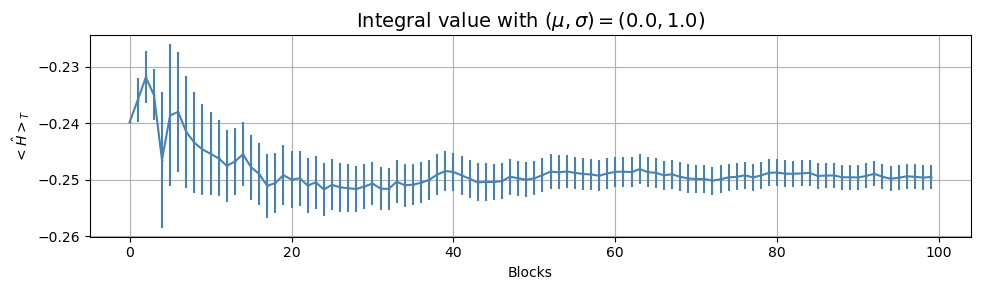

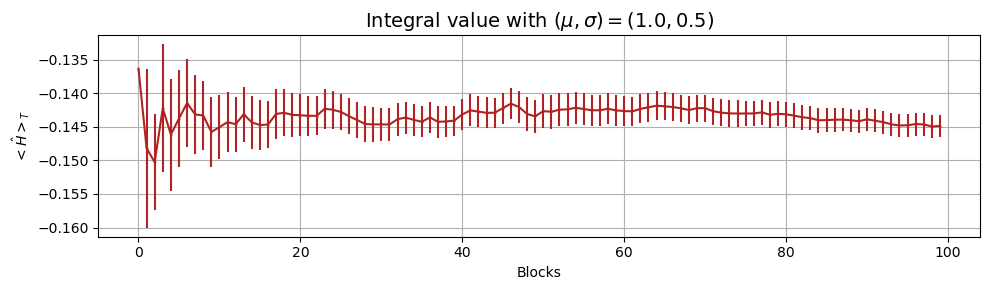

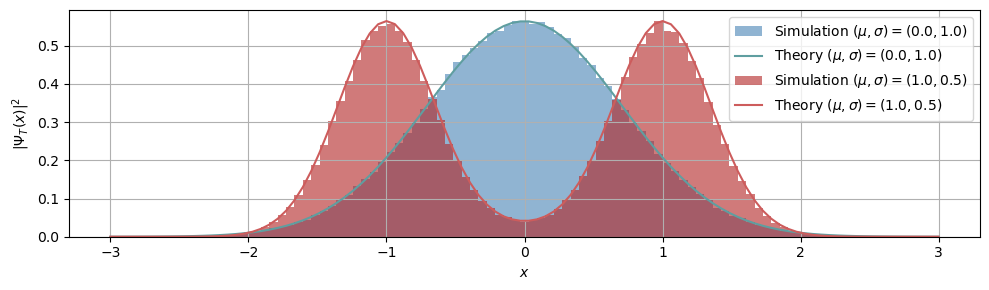

In [19]:
# Function to evaluate the squared wavefunction
def EvalWaveFunctionSquared(x, mu, sigma):
    return (np.exp(-(x-mu)**2/(2*sigma**2))+np.exp((-(x+mu)**2/(2*sigma**2))))**2

# Function to generate a graph for the Hamiltonian
def hamiltonianGraph(mu, sigma, color):
    # Convert float to string with 3 decimal places
    mu_str = f"{mu:.1f}"
    sigma_str = f"{sigma:.1f}"

    plt.figure(figsize=(10, 3))
    x, y, error = np.loadtxt(f'./8.1/HamiltonianExpValue_{mu_str}_{sigma_str}.dat', unpack=True, usecols=(0, 2, 3))
    plt.errorbar(x, y, yerr=error, marker='o', markersize=0.5, label=f'$(\mu,\sigma) = ({mu_str},{sigma_str})$', color=color)
    plt.title(f'Integral value with $(\mu,\sigma) = ({mu_str},{sigma_str})$', fontsize=14)
    plt.ylabel('$<\\hat{H}>_T$')
    plt.xlabel('Blocks')
    plt.grid()
    plt.tight_layout()
    plt.show()

# Function to generate a histogram for the wavefunction
def wavefunctionHisto(mu, sigma, norm, color1, color2):
    # Convert float to string with 3 decimal places
    mu_str = f"{mu:.1f}"
    sigma_str = f"{sigma:.1f}"

    positions = np.loadtxt(f'./8.1/Coordinates_{mu_str}_{sigma_str}.dat', usecols=(1))
    plt.hist(positions, density=True, bins=np.linspace(-3, 3, 100), label=f'Simulation $(\mu,\sigma) = ({mu_str},{sigma_str})$', alpha=0.6, color=color1)
    plt.plot(np.linspace(-3, 3, 100), 1 / (norm*np.sqrt(np.pi)) * EvalWaveFunctionSquared(np.linspace(-3, 3, 100), mu, sigma), color=color2, label=f'Theory $(\mu,\sigma) = ({mu_str},{sigma_str})$')


# Test the functions with formatted floats
hamiltonianGraph(0.0, 1.0, colors[0])
hamiltonianGraph(1.0, 0.5, colors[1])


plt.figure(figsize=(10, 3))
wavefunctionHisto(0.0, 1.0, 4, colors[0], colors[2])
wavefunctionHisto(1.0, 0.5, 1, colors[1], colors[3])

plt.legend()
plt.xlabel('$x$')
plt.ylabel('$|\\Psi_T(x)|^2$')
plt.grid()
plt.tight_layout()
plt.show()


The fact that the histograms of explored positions resemble so closely the analytic expressions of the wavefunctions is a test for the Metropolis algorithm: it confirms that position with higher associated probability were visited relatively more times than others.

## 8.2

To find the parameters $\sigma$ and $\mu$ which minimize $\langle {\hat H} \rangle_T$, extend your Variational Monte Carlo code to face the variational optimization problem via a Simulated Annealing (SA) algorithm.

Choose an appropriate starting temperature for your SA algorithm and an appropriate temperature-update-law to make the optimization work.

Compute $\langle {\hat H} \rangle_T$ with enough statistics in order to be able to measure the lowering of $\langle {\hat H} \rangle_T$ once the variational parameters are moved.
- Show a picture of $\langle {\hat H} \rangle_T$ (with statistical uncertainties) as a function of the SA steps of the algorithm
- you could also show a picture of the trajectory of the SA algorithm in the variational parameter space as a function of the SA steps
- show a picture of the estimation of $\langle {\hat H} \rangle_T$ and its statistical uncertainty as a function of the number of blocks/MC steps for the set of parameters which minimize $\langle {\hat H} \rangle_T$
- show also a picture **of the sampled** $|\Psi_T(x)|^2$ by filling a histogram with the sampled configurations, moreover compare it with the analytic curve of $|\Psi_T(x)|^2$ and with the numerical solution obtained by transforming the Schrodinger equation into a matrix equation (see below the supplementary material).

Ground state energy:  -0.4604658796923901
1st excited state energy:  0.09742471331806084
2nd excited state energy:  1.9717331343935816


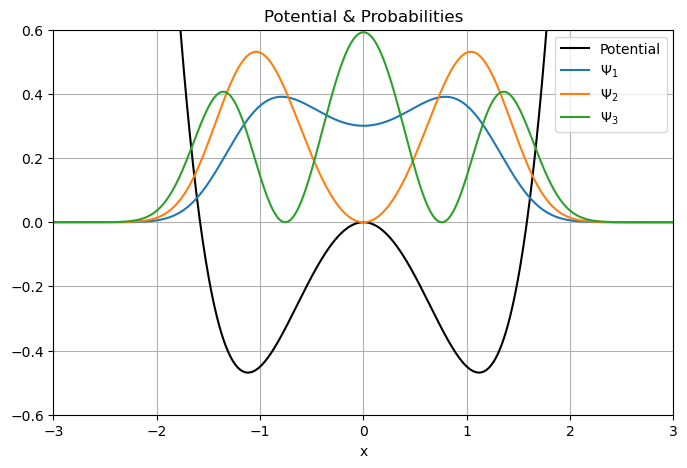

In [23]:
# Matrix solution, see supplementary material for details
def Vpot(x):
    return (x**2 - 2.5)*x**2
    #return 0.5*x**2

hbar = 1
m = 1
a = 10
N = 1000 # number of iterations

# Step sizes
x = np.linspace(-a/2, a/2, N)
dx = x[1] - x[0] # the step size
V = Vpot(x)

# The central differences method: f" = (f_1 - 2*f_0 + f_-1)/dx^2

CDiff = np.diag(np.ones(N-1),-1)-2*np.diag(np.ones(N),0)+np.diag(np.ones(N-1),1)
# np.diag(np.array,k) construct a "diagonal" matrix using the np.array
# The default is k=0. Use k>0 for diagonals above the main diagonal, 
# and k<0 for diagonals below the main diagonal

# Hamiltonian matrix
H = (-(hbar**2)*CDiff)/(2*m*dx**2) + np.diag(V)

# Compute eigenvectors and their eigenvalues
E,psi = np.linalg.eigh(H)

# Take the transpose & normalize
psi = np.transpose(psi)
psi = psi/np.sqrt(dx)

print("Ground state energy: ", E[0])
print("1st excited state energy: ", E[1])
print("2nd excited state energy: ", E[2])

# Plot a few things
plt.figure(figsize=(8,5))
scale = 0.3
plt.plot(x, scale*V, color="Black", label="Potential") # plot the potential
plt.plot(x,(psi[0])**2, label = '$\Psi_1$')
plt.plot(x,(psi[1])**2, label = '$\Psi_2$')
plt.plot(x,(psi[2])**2, label = '$\Psi_3$')
plt.title("Potential & Probabilities")
plt.xlabel("x")
plt.grid(True)
plt.xlim((-3,3))
plt.ylim((-0.6,0.6))
plt.legend()
plt.show()

## Solution

### Simulated annealing
The method of simulated annealing is essentially an analogy to how liquids freezes and crystallize or metals cool and anneal. For example a liquid at high temperatures that is brought slowly down to a much lower temperature, enough to transition to a solid, can independently find its lowest state of energy in the new configuration. In fact, if the process of cooling happens slowly enough, at a molecular level the atoms in the liquid are able to line themselves up forming the crystal configuration that characterizes a solid crystal and which is the lowest energy state. This organization can reach depths quite suprising, with crystals forming exactly the same and repeating at distances up to billions of times the size of an indivudal atom in all directions.
<br> On the other hand if the cooling is too quick, an intermediate state forms, which is less ordered and of higher energy. 

The essence of this slow cooling is in fact the time we give the system to find its ground state. In practice, any optimization problem can be tackled exploiting an annealing method. The cost function of the optimization can be thought of as the energy of a statistical-mechanics system and with the Boltzman distribution $p(x) = e^{-\beta\hat H / Z}$ which becomes gradually more concentrated as the system cools i.e. as $\beta\rightarrow\infty$.
<br> The system esentially takes a certain number of steps for each value of temperature (they can be different with varying $\beta$). Mathematically this is a time-dependent Markov chain. Sampling this with a Boltzmann weight allows us to construct a Metropolis algorithm with interesting properties. In fact, the sampling depends on $\beta$: at high temperatures, the system does not care much about the energy and explores the space more freely (accepting moves both with or against the gradient), while at low temperatures the system only accepts downhill steps, ultimately reaching the minimum of the energy. 
If the system is ergodic, the minimum of the energy reached is very likely to be the global minimum of the cost function, i.e. the ground state. Usually, the ground state is reached only approximately, but is usually sufficient for most applications.

The value of $\beta$ is also used as the side of the square in the parameter space $(\sigma,\mu)$ explored at each step. This allows also to propose steps depending on the temperature of the system: at the beginning, the parameters can vary significantly, allowing a wider space to be explored, while as time goes by it is useful that the parameters vary less so that the set does not jump out of the valley it should have found.

### Code implementation
The library needed for this point was the same as the previous as no functions needed to be built. 
Thus the process of annealing was implemented directly in the `main.cpp` inside the directory `LSN_08/8.2`, where the evaluation of the Hamiltonian expectation value on the wavefunction, which was the sole purpose of the previous exercise, will now take its place inside the _while loop_ which will take care of the annealing process. Let us take a look at the core steps of the simulation.

The temperature of the system was initialized at $T=2$ and a minimum value was set at $T_{min} = 0.1$. The while loop and the updating conditions look like
```cpp
while (T >= TMin) {
  (...)
  step += 1;
  T *= 0.997 ;
  beta = 1. / T;
}
```
The annealing was constructed, as can be seen, with a multiplicative update of $T$, which allows us to take only a single step for each value of $\beta$, but as $T$ gets smaller, each update varies it always by a smaller amount (being the update multiplicative). Thus the process of cooling slows down with time so that the system isn't forced. 

Once the temperature is updated, we need to generate new parametrs for the wavefunction. Here are the lines that take care of this at the beginning of the loop:
```cpp
mu = abs(muOld + rand.Rannyu(-1.,1.) * 0.5 * T) ;
sigma = abs(sigmaOld + rand.Rannyu(-1.,1.) * 0.25 * T) ; 
```
As we can see, the generation of the new parameter is around the old ones (muOld and sigmaOld) with range of the random draw dependent on temperature. The additional multiplicative parameters before the temperatures were added upon observing that the sole temperature gave too wide of a range for the parameters to change, which made the simulation converge with more difficulty. 

Now with the updated parameters, the usual loops took care of the block averaging, so that at the end we had an estimate of the Hamiltonian expectation value on the wavefunciton with our trial parameters. With the result saved in a variable simply called `energy`, and the energy from the previous step called `energyOld`, the acceptance of 
```cpp
double acceptance = min(1., (exp(- beta * (energy - energyOld))));
	
if (rand.Rannyu() < acceptance){
  energyOld = energy;
  muOld = mu; 
  sigmaOld = sigma;
} else {
  mu = muOld;
  sigma = sigmaOld;
}
```
So that the new parameters were accepted with probability `acceptance` and saved in the variables "Old" in order to generate the new parameters accordingly at the beginning of the following loop. 

Finally, in order to keep track of the best parameters found, i.e. the set which gave the lowest energy, these lines were added:
```cpp
if (bestEnergy > energy) {
  bestEnergy = energy;
  muBest = mu;
  sigmaBest = sigma;
}
```
So that at the end of the _while_, sigmaBest and muBest contained the values of parameters of the ground state wavefunction. 

### Ground state wavefunction plot
Below I am showing the plot of the wavefunction with parameters found from simulated annealing and the orogressive energy value. This was done simply by copying the code of the exercise 8.1 and letting it take as parameters sigmaBest and muBest. The plots show the comparison with analytic solution of $\Psi_T$ together with the matrix solution of the system, described in the [Supplementary material section](#supplementary-material) and calculated in the python script before the beginning of the solution.

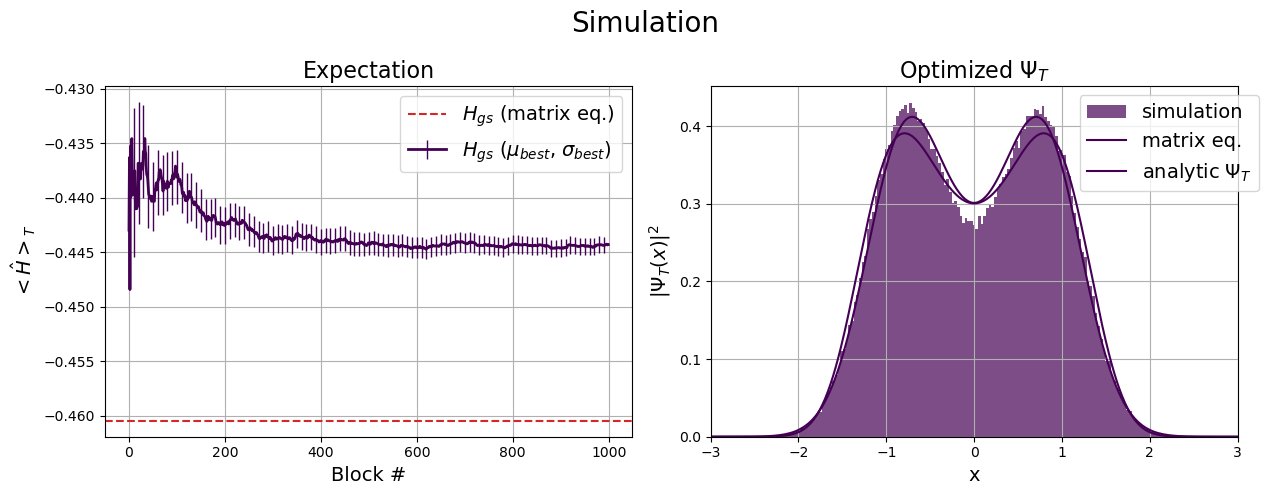

In [22]:
fig = plt.figure(figsize=(13, 5))
fig.suptitle('Simulation', fontsize=20)

plt.subplot(1, 2, 1)

# Definition of the trial wave function used for plotting analytical results
def TWF(x, mu, sigma):
    return (np.exp(-(x - mu) ** 2 / (2 * sigma ** 2)) + np.exp((-(x + mu) ** 2 / (2 * sigma ** 2)))) ** 2

# Load data
energy = np.loadtxt('./8.2/GSHamiltonianExpValue.dat', usecols=(0, 2, 3))
plt.errorbar(energy[:, 0], energy[:, 1], yerr=energy[:, 2], errorevery=10, c=colors[0], lw=2, elinewidth=1,
             ecolor=colors[2], label=r'$H_{gs}$ ($\mu_{best}$, $\sigma_{best}$)')

# Assuming E is defined somewhere
plt.axhline(E[0], ls='--', c='tab:red', label=r'$H_{gs}$ (matrix eq.)')

plt.grid()
plt.title('Expectation', fontsize=16)
plt.ylabel('$<\hat{H}>_T$', fontsize=14)
plt.xlabel('Block #', fontsize=14)
plt.legend(fontsize=14)

plt.subplot(1, 2, 2)

plt.title('Optimized $\Psi_{T}$', fontsize=16)

x = np.linspace(-a/2, a/2, N)

positions = np.loadtxt('./8.2/GSCoordinates.dat', usecols=(1))
plt.hist(positions, density=True, bins=np.linspace(-3, 3, 200), label='simulation', color=colors[0], alpha=0.7)
plt.plot(x, (psi[0]) ** 2, color=colors[3], label='matrix eq.')
plt.plot(np.linspace(-3, 3, 200), (1 / (1.5 * np.sqrt(np.pi))) * TWF(np.linspace(-3, 3, 200), 0.7902, 0.623073),
         color=colors[1], label='analytic $\Psi_T$')
plt.legend(fontsize=14, loc=(0.7, 0.7))
plt.xlabel('x', fontsize=14)
plt.ylabel('$|\Psi_T(x)|^2$', fontsize=14)
plt.grid()

plt.xlim(-3, 3)

plt.tight_layout()
plt.show()


Finally below I thought interesting to visualize what happened in the parameter space exploration.

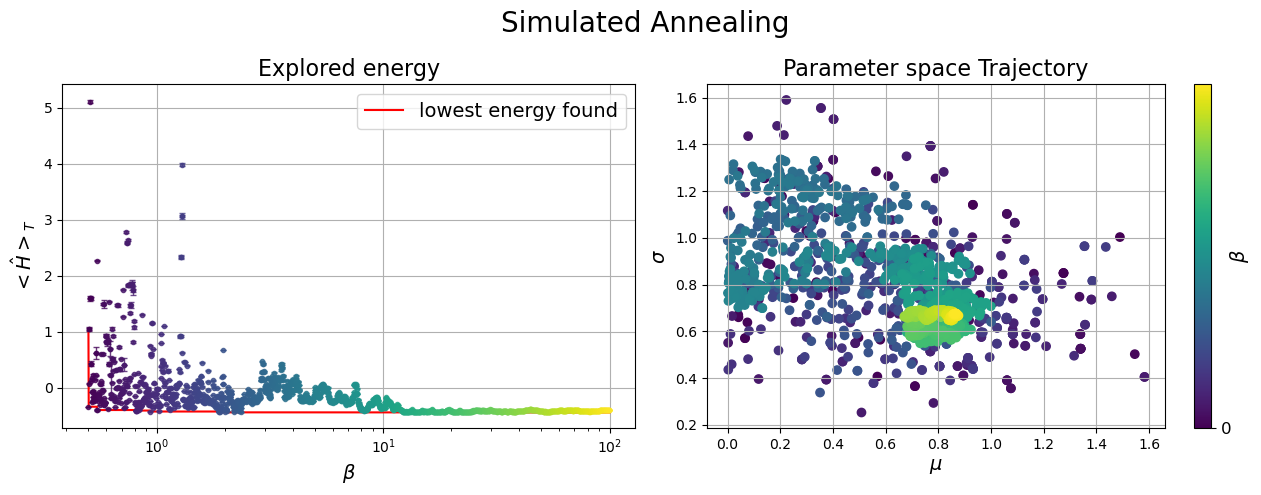

In [25]:
plt.figure(figsize=(13,5))
plt.suptitle('Simulated Annealing', fontsize=20)

# Load data
energy = np.loadtxt('./8.2/HamiltonianExpValue.dat', usecols=(1, 4, 5, 6))
betas = 1 / energy[:, 0]
parameters = np.loadtxt('./8.2/HamiltonianExpValue.dat', usecols=(2, 3))

# Left subplot
ax1 = plt.subplot(1,2,1)
plt.plot(betas, energy[:,2], c='red', label='lowest energy found')

# Create colormap
cmap = plt.cm.viridis  
colors = cmap(np.linspace(0, 1, len(np.unique(betas))))  # Generate colors based on unique betas
color_map = {beta: color for beta, color in zip(np.unique(betas), colors)}  # Map betas to colors

# Plot points with colors based on betas
for beta, (x, y, yerr) in zip(betas, zip(betas, energy[:,1], energy[:,3])):
    plt.errorbar(x, y, yerr=yerr, fmt='o', c=color_map[beta], alpha=0.8, markersize=3, elinewidth=1, capsize=2, capthick=1)

plt.xlabel('$\\beta$',fontsize=14)
plt.ylabel('$<\hat{H}>_T$', fontsize=14)
#plt.yscale('symlog', linthresh=0.1)
plt.xscale('log')
plt.legend(fontsize=14)
plt.grid()
plt.title('Explored energy', fontsize=16)

# Right subplot
plt.subplot(1,2,2)
cmap = plt.cm.viridis  
colors = cmap(np.linspace(0, 1, len(np.unique(betas))))  # Generate colors based on unique betas
plt.scatter(parameters[:, 0], parameters[:, 1], c=colors[np.unique(betas, return_inverse=True)[1]])

plt.xlabel('$\mu$', fontsize=14)
plt.ylabel('$\sigma$', fontsize=14)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=12)
cbar.set_label('$\\beta$', fontsize=14)
cbar.ax.yaxis.set_label_coords(2.0, 0.5)

locator = FixedLocator(np.linspace(min(betas), max(betas), 6, dtype=int))
cbar.set_ticks(locator)
cbar.set_ticklabels(np.linspace(min(betas), max(betas), 6, dtype=int))
plt.grid()
plt.title('Parameter space Trajectory', fontsize=16)

plt.tight_layout()
plt.show()

The Hamiltonian can be seen varying significantly at the beginning, with some steps taken evidently out of the downhill direction of the gradient. This is mirrored in the behavior of the explored parameters in the parameter space: the darker ones show a wide distribution. As time goes by howevever, the distribution narrows down and the energy gets progressively lower and varies always less.

### Conclusions
Through the graphs produced we can say that the simulated annealing algorithm did not quite find the precise ground state but rather a good approximation. The energy of the wavefunction explored is in fact about $0.015$ higher than the ground state energy, however from the plots we can see that the wavefunction with the best parameters is very close to the analytic and matrix solutions.

To improve our solution, we could give the system more time to anneal (with a higher starting temperature for example, or lower ending temperature) or to modify the initial parameters. However, we knew from the beginning that the system would only approximate a solution.

## Supplementary material

How can we describe a wave function as a vector? We set up a lattice of discrete points, spaced by a constant distance $dx$, and record the value of the function at each lattice point. In this way the wave function, $\Psi(x)$ become a vector:

$$
\Psi(x) \to \left[ \Psi(x_1), \Psi(x_2), ..., \Psi(x_N) \right] = 
\left[ \Psi_1, \Psi_2, ..., \Psi_N \right]
$$

The time independent Schrodinger equation 

$$
{\hat H} \Psi(x) = \left( -\frac{\hbar^2}{2m}\frac{\partial^2}{\partial x^2} + V(x) \right) \Psi(x) = E \Psi(x)
$$

can be written in matrix form. But how do we write the second derivative at a particular point? Let's start with the first derivatives:
$$
\frac{\partial}{\partial x} \Psi\left(x=(x_i+x_{i+1})/2\right) \simeq \frac{\Psi_{i+1}-\Psi_{i}}{dx}\\
\frac{\partial}{\partial x} \Psi\left(x=(x_i+x_{i-1})/2\right) \simeq \frac{\Psi_{i}-\Psi_{i-1}}{dx}
$$

Thus, we can discretize the second derivative in the following way:
$$
\frac{\partial^2}{\partial x^2} \Psi(x=x_i) =
\frac{\frac{\partial}{\partial x} \Psi\left(x=(x_i+x_{i+1})/2\right) - \frac{\partial}{\partial x} \Psi\left(x=(x_i+x_{i-1})/2\right)}{dx} =
\frac{\Psi_{i+1}-2\Psi_{i}+\Psi_{i-1}}{dx^2}
$$

We finally obtain:

$$
\begin{bmatrix}
 \frac{\hbar^2}{m\,dx^2}+V(x_1)& -\frac{\hbar^2}{2m\,dx^2} & 0 & \dots  & 0 \\
-\frac{\hbar^2}{2m\,dx^2} & \frac{\hbar^2}{m\,dx^2}+V(x_2) & -\frac{\hbar^2}{2m\,dx^2} & \dots  & 0 \\
 0                        & -\frac{\hbar^2}{2m\,dx^2} & \frac{\hbar^2}{m\,dx^2}+V(x_3) & \dots  & 0 \\
 \vdots                   & \vdots                    & \vdots & \ddots & \vdots \\
 0                    & 0                & 0 & \dots  & \frac{\hbar^2}{m\,dx^2}+V(x_N)
\end{bmatrix}
\begin{bmatrix}
\Psi_{1} \\
\Psi_{2} \\
\vdots \\
\Psi_{N}
\end{bmatrix}
= E
\begin{bmatrix}
\Psi_{1} \\
\Psi_{2} \\
\vdots \\
\Psi_{N}
\end{bmatrix}
$$

To solve the time independent Schrodinger equation we therefore have to find eigenstates and eigenvalues of the matrix just obtained.